**Các thay đổi chính:**
- Đổi qua sử dụng mô hình MobileNetV2 thay vì VGG16.
- Tiền xử lý ảnh tải từ Google (nếu có sử dụng) giống dữ liệu huấn luyện.
- Giảm classnames trong tệp huấn luyện từ 5 -> 3.
- Rebuild lại tệp dữ liệu:
  + Phiên bản 19.03.2025 phạm 1 lỗi nghiêm trong là để tệp Test và tệp Training y hệt nhau (vi phạm nguyên tắc cơ bản trong máy học: tập kiểm tra phải độc lập với tập huấn luyện)
  + Phiên bản 19.03.2025 train theo mô hình VGG16:
    - Dễ gây ra Overfitting nặng nếu tập dữ liệu không đủ lớn.
    - Quá nặng để chạy và xử lý mượt mà trên Raspberry.

---------------------------------------
**Kết quả:**
- Mô hình đã nhận diện chính xác ảnh từ bên ngoài với độ tin cậy > 80%.
- Có dấu hiệu Over fitting khá cao, cần điều chỉnh thêm ở phiên bản tiếp theo.


Liên kết đến Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Hàm tạo mô hình MobilenetV2

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import matplotlib.pyplot as plt
import json

def train_mobilenetv2_model(train_dir, val_dir, num_classes=5, epochs=50, model_save_path='mobilenetv2_fruits.h5', tflite_save_path='mobilenetv2_fruits.tflite'):
    """
    Huấn luyện mô hình MobileNetV2 cho bài toán phân loại ảnh.

    Args:
        train_dir (str): Đường dẫn đến thư mục chứa dữ liệu huấn luyện.
        val_dir (str): Đường dẫn đến thư mục chứa dữ liệu validation.
        num_classes (int): Số lượng lớp (mặc định là 3: 'Apple', 'Banana', 'Orange').
        epochs (int): Số epoch tối đa để huấn luyện.
        model_save_path (str): Đường dẫn để lưu mô hình .h5.
        tflite_save_path (str): Đường dẫn để lưu mô hình TFLite.

    Returns:
        history: Lịch sử huấn luyện (accuracy, loss qua các epoch).
    """
    # 1. Tạo ImageDataGenerator để tải và tiền xử lý dữ liệu ảnh
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5, 1.5],
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    # Kiểm tra số lượng ảnh trong mỗi lớp
    print("Số lượng ảnh trong tập huấn luyện:")
    for cls in train_generator.class_indices.keys():
        cls_path = os.path.join(train_dir, cls)
        num_images = len(os.listdir(cls_path))
        print(f"{cls}: {num_images} ảnh")
        if num_images < 10:
            print(f"Cảnh báo: Lớp {cls} có quá ít ảnh ({num_images}), có thể ảnh hưởng đến hiệu suất!")

    print("\nSố lượng ảnh trong tập validation:")
    for cls in val_generator.class_indices.keys():
        cls_path = os.path.join(val_dir, cls)
        num_images = len(os.listdir(cls_path))
        print(f"{cls}: {num_images} ảnh")
        if num_images < 3:
            print(f"Cảnh báo: Lớp {cls} có quá ít ảnh ({num_images}), không đủ để đánh giá hiệu suất!")

    # 2. Tạo mô hình MobileNetV2
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False  # Đóng băng các tầng để giảm overfitting

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)  # Thêm Dropout để giảm overfitting
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Biên dịch mô hình
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # 3. Thêm callback để tối ưu hóa huấn luyện
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6
    )

    # 4. Huấn luyện mô hình
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[early_stopping, reduce_lr]
    )

    # 5. Lưu mô hình .h5
    model.save(model_save_path)
    print(f"Mô hình đã được lưu tại: {model_save_path}")

    # 6. Chuyển mô hình sang TFLite
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Tối ưu hóa để tăng tốc độ
    tflite_model = converter.convert()

    with open(tflite_save_path, 'wb') as f:
        f.write(tflite_model)
    print(f"Mô hình TFLite đã được lưu tại: {tflite_save_path}")

    # 7. Lưu lịch sử huấn luyện
    history_dict = {
        'loss': history.history['loss'],
        'accuracy': history.history['accuracy'],
        'val_loss': history.history['val_loss'],
        'val_accuracy': history.history['val_accuracy']
    }
    with open('training_history.json', 'w') as f:
        json.dump(history_dict, f)
    print("Lịch sử huấn luyện đã được lưu tại: training_history.json")

    # 8. Vẽ biểu đồ accuracy và loss
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_plots.png')
    print("Biểu đồ huấn luyện đã được lưu tại: training_plots.png")

    return history

Sử dụng hàm

Found 125 images belonging to 3 classes.
Found 16 images belonging to 3 classes.
Số lượng ảnh trong tập huấn luyện:
Apple: 45 ảnh
Banana: 40 ảnh
Orange: 40 ảnh

Số lượng ảnh trong tập validation:
Apple: 6 ảnh
Banana: 5 ảnh
Orange: 5 ảnh
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 9s/step - accuracy: 0.5668 - loss: 1.0222 - val_accuracy: 1.0000 - val_loss: 0.2203 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.8600 - loss: 0.3830 - val_accuracy: 1.0000 - val_loss: 0.1338 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.9358 - loss: 0.1950 - val_accuracy: 1.0000 - val_loss: 0.0725 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.9799 - loss: 0.1251 - val_accuracy: 0.9375 - val_loss: 0.1189 - learning_rate: 0.0010
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.9584 - loss: 0.1071 - val_accuracy: 0.8750 - val_loss: 0.1850 - learning_rate: 0.0010
Epoch 6/50
4/4 ━━━━━━━━

Mô hình đã được lưu tại: FruitsClassifi_MobileNetV2.h5
Saved artifact at '/tmp/tmpe1wecd3g'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_158')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  133312593762000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133312593762384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133312593762960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133312593762576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133312593761232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133312593764304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133312593764688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133312593765072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133312593764880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133312593760272: TensorSp

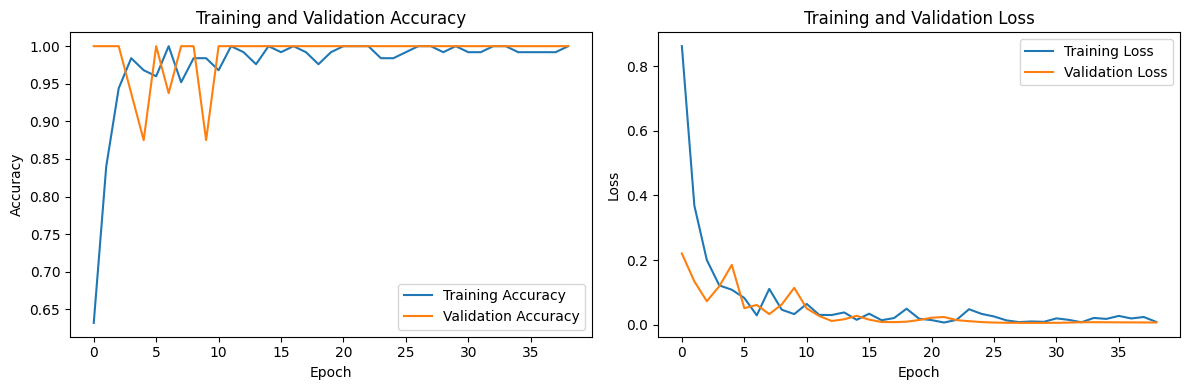

In [8]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/CustomDatasetFruits/Version 20.03.2025/Training'
valid_dir = '/content/drive/MyDrive/Colab Notebooks/CustomDatasetFruits/Version 20.03.2025/Validation'
test_dir = '/content/drive/MyDrive/Colab Notebooks/CustomDatasetFruits/Version 20.03.2025/Testing'

history = train_mobilenetv2_model(train_dir, valid_dir, num_classes=3, model_save_path='FruitsClassifi_MobileNetV2.h5', tflite_save_path='FruitsClassifi_MobileNetV2.tflite')

Đánh giá trên tập Test

In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Found 16 images belonging to 3 classes.


NameError: name 'model' is not defined

Thử nghiệm mô hình

Ảnh đã được tải thành công!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Dự đoán: Banana với độ tin cậy 99.97%


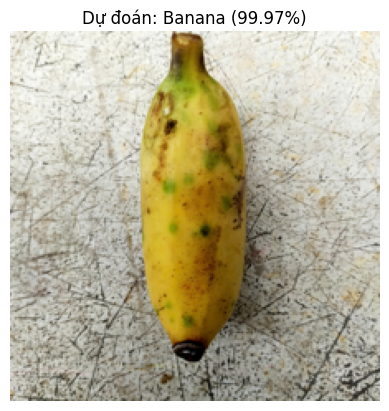

In [15]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# model_path = '/content/drive/MyDrive/Colab Notebooks/Results/mobilenetv2_fruits_20032025.h5'     # Thay bằng đường dẫn đến file .h5 của bạn
# model_path = 'FruitsClassifi_MobileNetV2.h5'
# model = tf.keras.models.load_model(model_path)
# print("Mô hình đã được tải thành công!")

image_path = '/content/drive/MyDrive/Colab Notebooks/Test all/Banana New/Banana 4.jpg'              # Thay bằng đường dẫn đến ảnh của bạn
img = Image.open(image_path).resize((224, 224)).convert('RGB')                          # Resize ảnh về kích thước 224x224
img_array = np.array(img, dtype=np.float32) / 255.0                                     # Chuẩn hóa giá trị pixel về [0, 1]
img_array = np.expand_dims(img_array, axis=0)                                           # Thêm chiều batch (1, 224, 224, 3)
print("Ảnh đã được tải thành công!")

class_labels = ['Apple', 'Banana', 'Orange']
predictions = model.predict(img_array)
predicted_class = class_labels[np.argmax(predictions)]
confidence = np.max(predictions) * 100

print(f"Dự đoán: {predicted_class} với độ tin cậy {confidence:.2f}%")

plt.imshow(img)
plt.title(f"Dự đoán: {predicted_class} ({confidence:.2f}%)")
plt.axis('off')
plt.show()
